In [1]:
import requests, re, time
from bs4 import BeautifulSoup
from selenium import webdriver
from forex_python.converter import CurrencyRates
import datetime
from db import Database


from time import sleep
def try_convert(st_price,auction_year,auction_month,auction_date):
    c = CurrencyRates()
    dateobj = datetime.date(int(auction_year), int(auction_month), int(auction_date))
    success = False
    # while success == False:
    #     try:
    #         try:
    #             st_price = c.convert('HKD', 'KRW', st_price, dateobj)
    #         except:
    #             st_price = c.convert('HKD', 'KRW', st_price)
    #         success = True
    #     except:
    #         #wait a while
    #         sleep(10)
    try:
        try:
            st_price = c.convert('HKD', 'KRW', st_price, dateobj)
        except:
            st_price = c.convert('HKD', 'KRW', st_price)
        success = True
    except:
        st_price = st_price*400
    return st_price

save_db = Database()

# Search parameters
driver = webdriver.Chrome('./chromedriver.exe')
driver.implicitly_wait(2)
driver.maximize_window()

# Search Page 
url = "https://www.seoulauction.com/search?lang=ko"
artist = '김환기'
ID = 'jeihyunsung'
PW = 'wpwp3008!'

# Login Task

driver.get(url)
driver.implicitly_wait(2)

driver.find_element_by_xpath('//*[@id="header"]/div[3]/ul/li[3]/a').click()

driver.find_element_by_xpath('//*[@id="loginId"]').send_keys(ID)
driver.implicitly_wait(2)
driver.find_element_by_xpath('//*[@id="password"]').send_keys(PW)
driver.implicitly_wait(2)
driver.find_element_by_xpath('//*[@id="loginForm"]/fieldset/div/div[3]/div[3]/span/button').click()
driver.implicitly_wait(2)

# search artist, button click
driver.find_element_by_xpath('//*[@id="container"]/div[3]/div/form/fieldset/div/div[1]/div[2]/dl[1]/dd/div/input[1]').send_keys(artist)
driver.implicitly_wait(2)
driver.find_element_by_css_selector('#container > div.contents_wrap > div > form > fieldset > div > div.btn_wrap > span.btn_style01.gray02 > button').click()
driver.implicitly_wait(2)
pages = int(driver.find_element_by_css_selector('#container > div.contents_wrap > div > form > div > div.left > div > paging > ul > li:nth-child(12) > a').text)
print("pages:", pages)
page = 0

element_id = 0

while(page < pages):
    print("get page : ", page)
    art_list = driver.find_elements_by_xpath('//*[@id="auctionList"]/li')
    for idx, element in enumerate(art_list):
        explain = element.find_element_by_class_name("auction_list_explain")
        description = explain.text

        try:
            size = explain.find_element_by_xpath('.//*[@ng-repeat="size in lot.LOT_SIZE_JSON"]').text
        except:
            size = 0
        try:
            method = explain.find_element_by_xpath('.//*[@ng-bind="lot.MATE_NM_EN"]').text
        except:
            method = ''
        try:
            year = explain.find_element_by_xpath('.//*[@ng-if="lot.MAKE_YEAR_JSON[locale]"]').text
        except:
            year = 0
        try:
            final_price = element.find_element_by_class_name("txt_impo").text
        except:
            final_price = ''
        
        # print(size, method, year, final_price, sep='/')

        st_price_txt = element.find_element_by_class_name("es_price_right").text
        auction_ect = element.find_element_by_class_name("auction_ect").text

        auction_ect = auction_ect.split('[')[1]
        auction_ect = auction_ect[:-1].split(' ')[0]
        auction_ect = auction_ect.split('.')
        auction_year, auction_month, auction_date = auction_ect[0], auction_ect[1], auction_ect[2][:-3] 

        # description = description.split('\n')
        # if len(description) == 3:
        #     year, method, size = description[0], description[1], description[2]
        # elif len(description) == 2:
        #     method, size = description[0], description[1]
        #     year = 0
        # elif len(description) == 1:
        #     method = description[0]
        #     year, size = 0, 0
        # elif len(description) == 0:
        #     size, year, method = 0, 0, ''

        # Year parsing
        if type(year) == str:            
            if "mid" in year:
                year = year.replace("’", '').replace("s", '').replace("'", '').replace("mid", '').replace('-','')
                year = int(year)
            elif "early" in year:
                year = int(year.replace("’", '').replace("s", '').replace("early ", ''))+4
            elif "-" in year:
                st = year.split('-')[0]
                ed = year.split('-')[1]
                if len(ed) == 2:
                    year = int(st[:2]+ed)
                else:
                    year = int(ed.replace('s',''))
            elif '.' in year:
                year = int(year.split('.')[0])
            elif "년대" in year:
                if "년대 초반" in year:
                    year = int(year.replace("년대 초반", "")) + 4
                elif "년대 초" in year:
                    year = int(year.replace("년대 초", "")) + 4
                elif "년대 후반" in year:
                    year = int(year.replace("년대 후반", "")) + 9
                else:
                    year = int(year.replace("년대", "")) + 9
            elif "’" in year or "s" in year or "'s" in year or "’s" in year:
                year = year.replace("’", '').replace("s", '').replace("'", '')
                year = int(year)+9
            else:
                try:
                    year = int(year)
                except:
                    year = year
                    print("## Year parsing Problem ##", year)

        # Size parsing
        if type(size) == str:
            if "cm" in size:
                sizeidx = size.index('cm')
                size = size[:sizeidx]
                size = size.replace("cm", '')
                x, y = float(size.split('☓')[0]), float(size.split('☓')[0])
                area = x*y
            else:
                print("## Size parsing problem", size)
                area = 0

        # Price parsing
        if "추정가 별도문의" in st_price_txt:
            st_price = 0
        elif "KRW" in st_price_txt:
            st_price_list = st_price_txt.split('\n')
            for x in st_price_list:
                if "KRW" in x: 
                    st_price = x.replace('KRW ','').replace(',', '')
                    st_price = int(st_price)
        elif "HKD" in st_price_txt:
            st_price = st_price_txt.split('\n')[0]
            st_price = st_price.replace('HKD ','').replace(',', '')
            st_price = int(st_price)
            st_price = try_convert(st_price,auction_year,auction_month,auction_date)
            # c = CurrencyRates()
            # dateobj = datetime.date(int(auction_year), int(auction_month), int(auction_date))
            # try:
            #     st_price = c.convert('HKD', 'KRW', st_price, dateobj)
            # except:
            #     st_price = c.convert('HKD', 'KRW', st_price)
        else:
            print("## Price parsing problem ", st_price_txt)
            st_price = 0
        
        # final price parsing

        if final_price == '':
            final_price = st_price
        else:
            if "KRW" in final_price:
                final_price = int(final_price.replace('낙찰가 ', '').replace('KRW ', '').replace(',',''))
            elif "HKD" in final_price:
                final_price = int(final_price.replace('낙찰가 ', '').replace('HKD ', '').replace(',',''))
                final_price = try_convert(final_price,auction_year,auction_month,auction_date)
                # c = CurrencyRates()
                # dateobj = datetime.date(int(auction_year), int(auction_month), int(auction_date))
                # try:
                #     st_price = c.convert('HKD', 'KRW', final_price, dateobj)
                # except:
                #     st_price = c.convert('HKD', 'KRW', final_price)
            else:
                print("## Final Price parsing problem ", final_price)

        # print(year, method, size, st_price, auction_year, auction_month, auction_date, sep='/')

        # Image extraction
        image = element.find_element_by_tag_name('img')
        image_src = image.get_attribute('ng-src')
        print(image_src)
        image_link = "https://www.seoulauction.com/" + image_src
        target_image = requests.get(image_link)
        with open(f'images/filename_{element_id}.jpg', 'wb') as file:
            file.write(target_image.content)

        data = [page, idx, year, method, area, st_price, final_price, auction_year, auction_month, auction_date]
        save_db.saveID(element_id, data)
        element_id += 1


    driver.find_element_by_xpath("//li[@title='Next Page']/a").click()
    page += 1
    time.sleep(5)

st/5d76879a-595c-4eee-9c84-a232d36f0466.jpg
/nas_img/front/main0460/list/f1be7be1-5fa0-4167-9365-1524df8d6678.jpg
/nas_img/front/main0460/list/c6a1a5d2-403c-4285-a6c8-1116fb782389.jpg
/nas_img/front/main0460/list/7ec14c32-cf96-4d6b-b511-4fb9c852cad5.jpg
/nas_img/front/main0452/list/d1ab9881-befb-4dd4-920c-724f8a1a6b06.jpg
/nas_img/front/main0452/list/5c035cd2-49c0-4aa7-8324-d48f25d0fe01.jpg
/nas_img/front/hongkong0442/list/ec6807b6-50c2-431c-80af-f4b1780dc57e.jpg
/nas_img/front/main0434/list/44047bb2-d187-465b-9d78-942064808f98.jpg
/nas_img/front/main0434/list/2212a3f0-01ad-46a3-a7df-20471c0fa351.jpg
get page :  3
/nas_img/front/main0434/list/bf0ab1d5-6bfd-4480-981e-0f58eef96637.jpg
/nas_img/front/main0434/list/8feed556-5f12-44cf-b642-76be2152b639.jpg
/nas_img/front/main0434/list/7bfaa3d7-1d2f-4252-a201-5177a99fb462.jpg
/nas_img/front/main0423/list/e6c35a6c-1b3c-4ea6-b2d6-2ccf4168f1c5.jpg
/nas_img/front/hongkong0420/list/ed208863-c80a-453c-bfcf-6a4d66405219.jpg
/nas_img/front/hongkong0

In [2]:

import pandas as pd
from db import Database

# train = pd.read_csv("Database.csv")

# save_db = Database_()
# element_id = 0
# data = [0, 0, 1900, 'oil', '300', '3000', '9000', '2021', '8', '21']
# save_db.saveID(element_id, data)

# db = pd.DataFrame({},columns = ['page', 'idx', 'year', 'method', 'area', 'st_price', 'final_price', 'auction_year', 'auction_month', 'auction_date'])
# db.loc[element_id]=data
# db.head()
# db.to_csv("Database.csv")


In [3]:
train = pd.read_csv("Database.csv")

train.head()

,Unnamed: 0,page,idx,year,method,area,st_price,final_price,auction_year,auction_month,auction_date
0,0,0,0,1968,"1) pencil on paper, 2) pencil and pen on paper",2070.25,15000000,24000000,2021,8,24
1,1,0,1,1968,oil on newspaper,3102.49,55000000,145000000,2021,8,24
2,2,0,2,1971,oil on cotton,28900.00,0,4000000000,2021,8,24
3,3,0,3,1969,oil on cotton,14641.00,650000000,650000000,2021,7,29
4,4,0,4,1966,oil on canvas,2550.25,320000000,320000000,2021,7,29


In [4]:
train.final_price.describe()

count    4.230000e+02
mean     6.341017e+08
std      2.241844e+09
min      0.000000e+00
25%      2.400000e+07
50%      8.100000e+07
75%      3.000000e+08
max      2.480000e+10
Name: final_price, dtype: float64

In [5]:
train.isnull().sum()

Unnamed: 0       0
page             0
idx              0
year             0
method           7
area             0
st_price         0
final_price      0
auction_year     0
auction_month    0
auction_date     0
dtype: int64

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [8]:
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = mpl.font_manager.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

[Text(0.5, 0, 'auction_year'), Text(0.5, 1.0, '경매년도')]

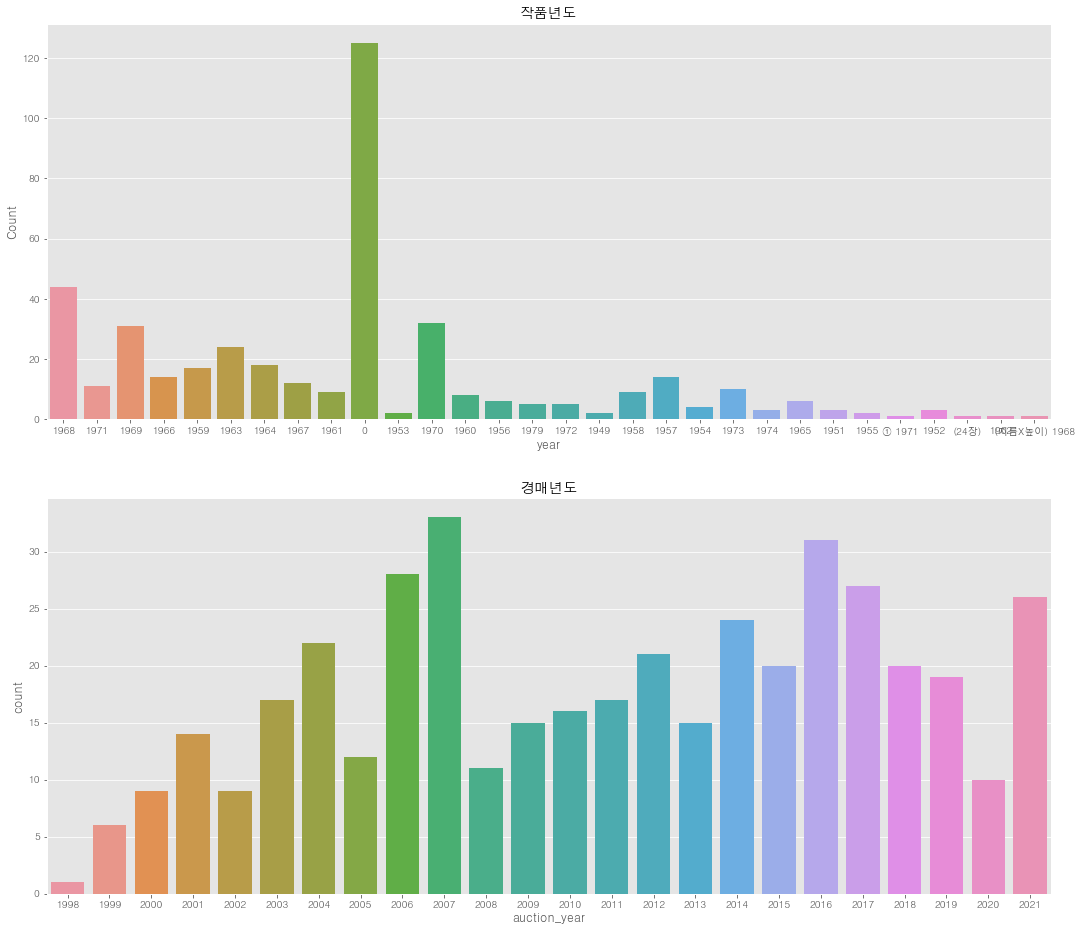

In [9]:
import seaborn as sns
from scipy import stats

figure, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18,16)

sns.countplot(data=train, x="year", ax=ax1)
sns.countplot(data=train, x="auction_year", ax=ax2)

ax1.set(ylabel='Count',xlabel='year',title="작품년도")
ax2.set(xlabel='auction_year',title="경매년도")

In [11]:
figure.savefig('savefig_default.png')

[Text(0.5, 0, 'year'), Text(0, 0.5, 'area'), Text(0.5, 1.0, '작품년도별 크기')]

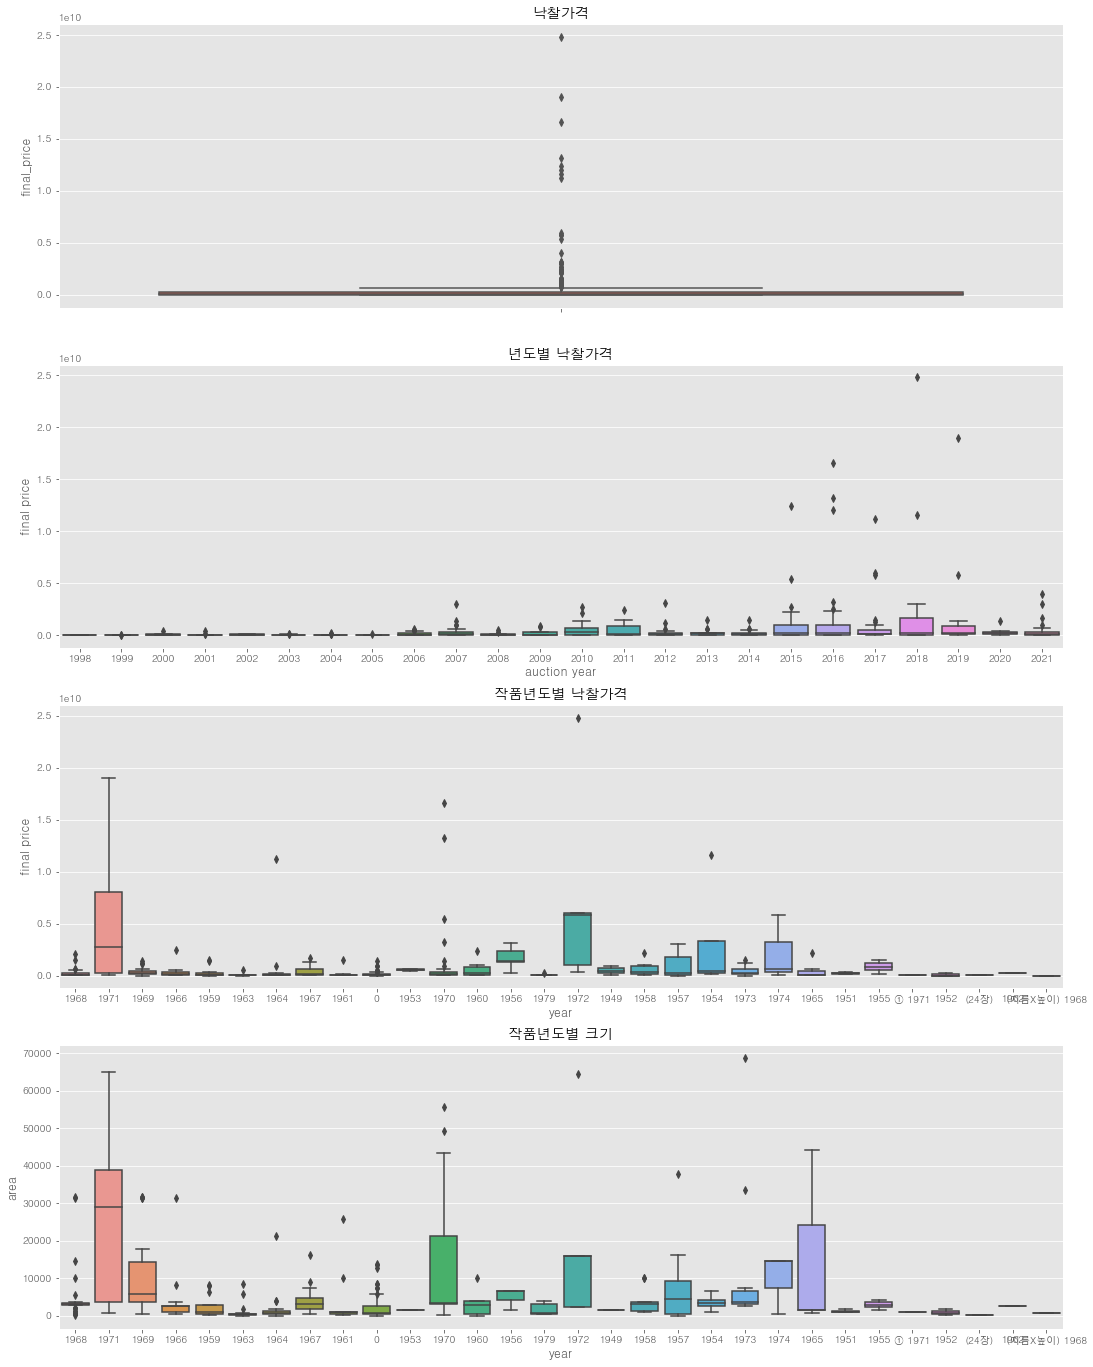

In [12]:
fig, axes = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(18, 24)

sns.boxplot(data=train,y="final_price",orient="v",ax=axes[0])
sns.boxplot(data=train,y="final_price",x="auction_year",orient="v",ax=axes[1])
sns.boxplot(data=train,y="final_price",x="year",orient="v",ax=axes[2])
sns.boxplot(data=train,y="area",x="year",orient="v",ax=axes[3])


axes[0].set(ylabel='final_price',title="낙찰가격")
axes[1].set(xlabel='auction year', ylabel='final price',title="년도별 낙찰가격")
axes[2].set(xlabel='year', ylabel='final price',title="작품년도별 낙찰가격")
axes[3].set(xlabel='year', ylabel='area',title="작품년도별 크기")

In [13]:
def concatenate_year_month(data):
    return "{0}-{1}".format(data['auction_year'], data['auction_month'])

train["year_month"] = train.apply(concatenate_year_month,axis=1)

print(train.shape)
train[["year_month"]].head()

(423, 12)


,year_month
0,2021-8
1,2021-8
2,2021-8
3,2021-7
4,2021-7


[Text(0.5, 0, 'auction time'),
 Text(0, 0.5, 'final price'),
 Text(0.5, 1.0, '시간별 낙찰가격')]

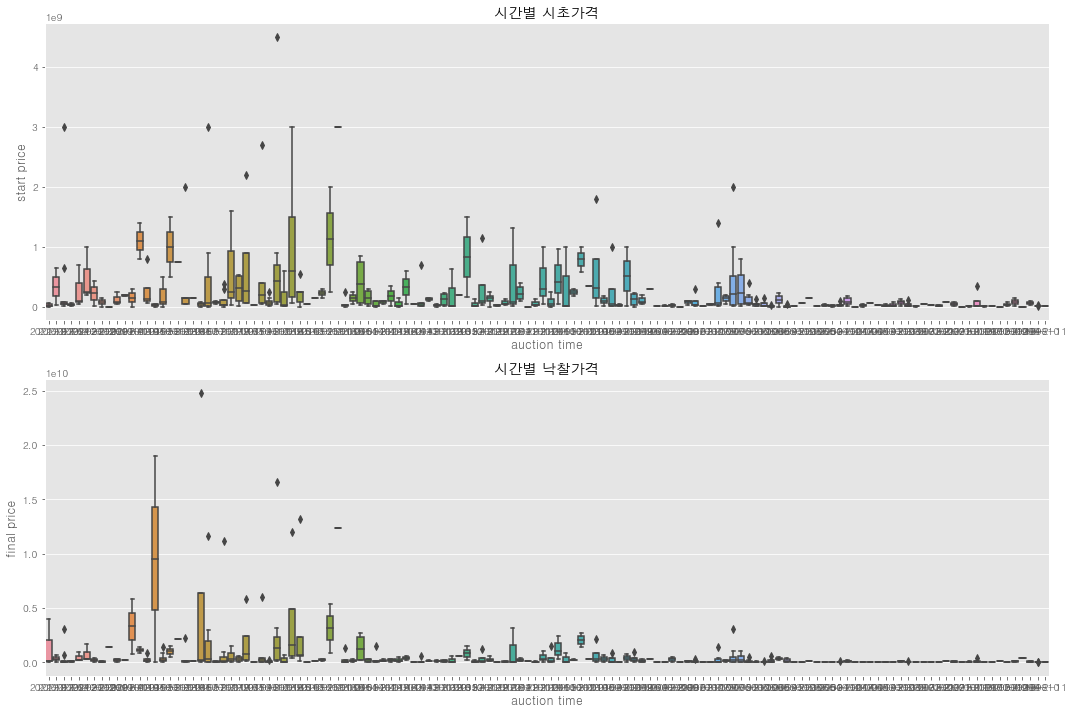

In [14]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18, 12)

sns.boxplot(data=train,y="st_price",x="year_month",orient="v",ax=axes[0])
sns.boxplot(data=train,y="final_price",x="year_month",orient="v",ax=axes[1])

axes[0].set(xlabel='auction time', ylabel='start price',title="시간별 시초가격")
axes[1].set(xlabel='auction time', ylabel='final price',title="시간별 낙찰가격")

In [15]:
def price_rise(data):
    return data['final_price']-data['st_price']

def price_rise_rate(data):
    if data['st_price'] != 0:
        return (data['final_price']-data['st_price'])/data['st_price']
    else:
        return 0

train["price_rise"] = train.apply(price_rise,axis=1)
train["price_rise_rate"] = train.apply(price_rise_rate,axis=1)
# train['price_rise'].head()
train['price_rise_rate'].head()

0    0.600000
1    1.636364
2    0.000000
3    0.000000
4    0.000000
Name: price_rise_rate, dtype: float64

[Text(0.5, 0, 'auction year'),
 Text(0, 0.5, 'price rise rate'),
 Text(0.5, 1.0, '년도별 낙찰가격상승률'),
 (0.0, 5.0)]

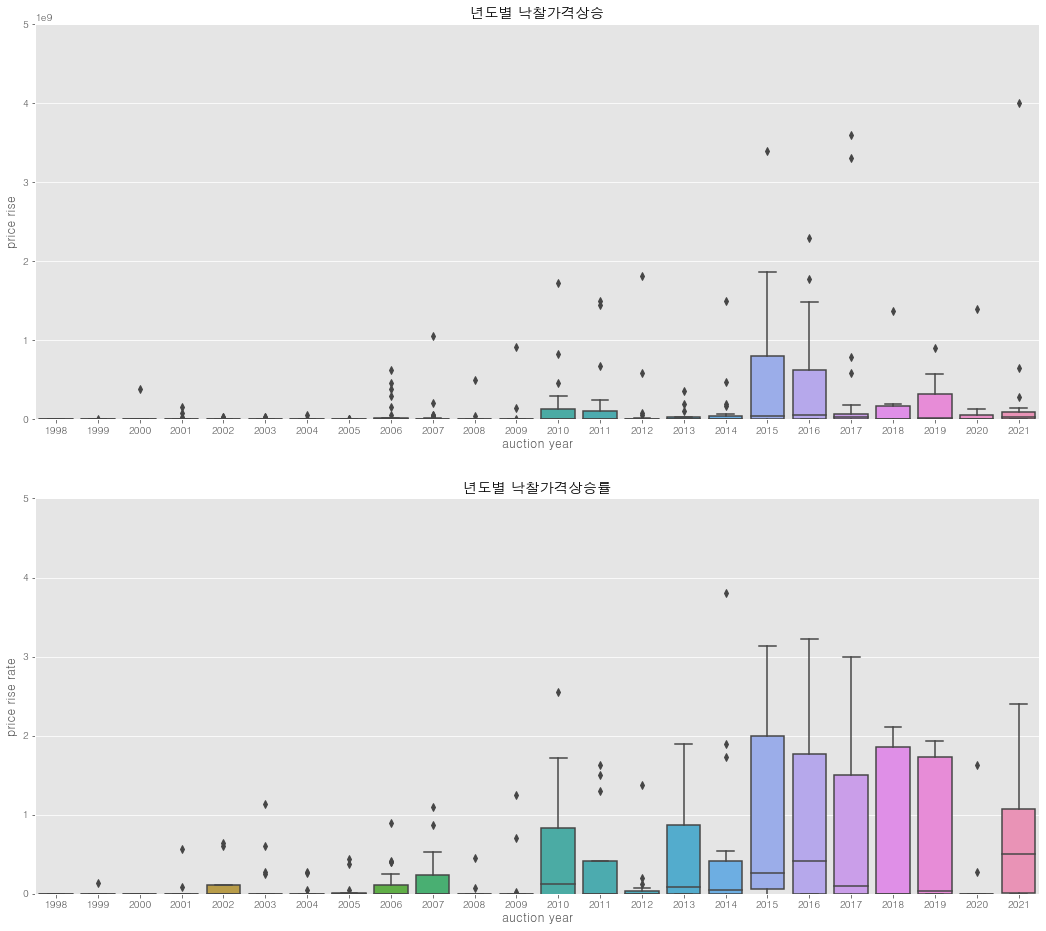

In [16]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18, 16)

sns.boxplot(data=train,y="price_rise",x="auction_year",orient="v",ax=axes[0])
sns.boxplot(data=train,y="price_rise_rate",x="auction_year",orient="v",ax=axes[1])

axes[0].set(xlabel='auction year', ylabel='price rise', title="년도별 낙찰가격상승",ylim=(0,0.5e10))
axes[1].set(xlabel='auction year', ylabel='price rise rate',title="년도별 낙찰가격상승률",ylim=(0,5))


In [17]:
fig.savefig('savefig_년도별낙찰가격상승.png')

In [41]:
def concatenate_year_month(data):
    return (data['auction_year']//10)*10

train["10year"] = train.apply(concatenate_year_month,axis=1)

print(train.shape)
train[["10year"]].head()

(423, 15)


,10year
0,2020
1,2020
2,2020
3,2020
4,2020


[Text(0.5, 0, 'years'),
 Text(0, 0.5, 'price rise rate'),
 Text(0.5, 1.0, '시대별 낙찰가격상승률'),
 (0.0, 5.0)]

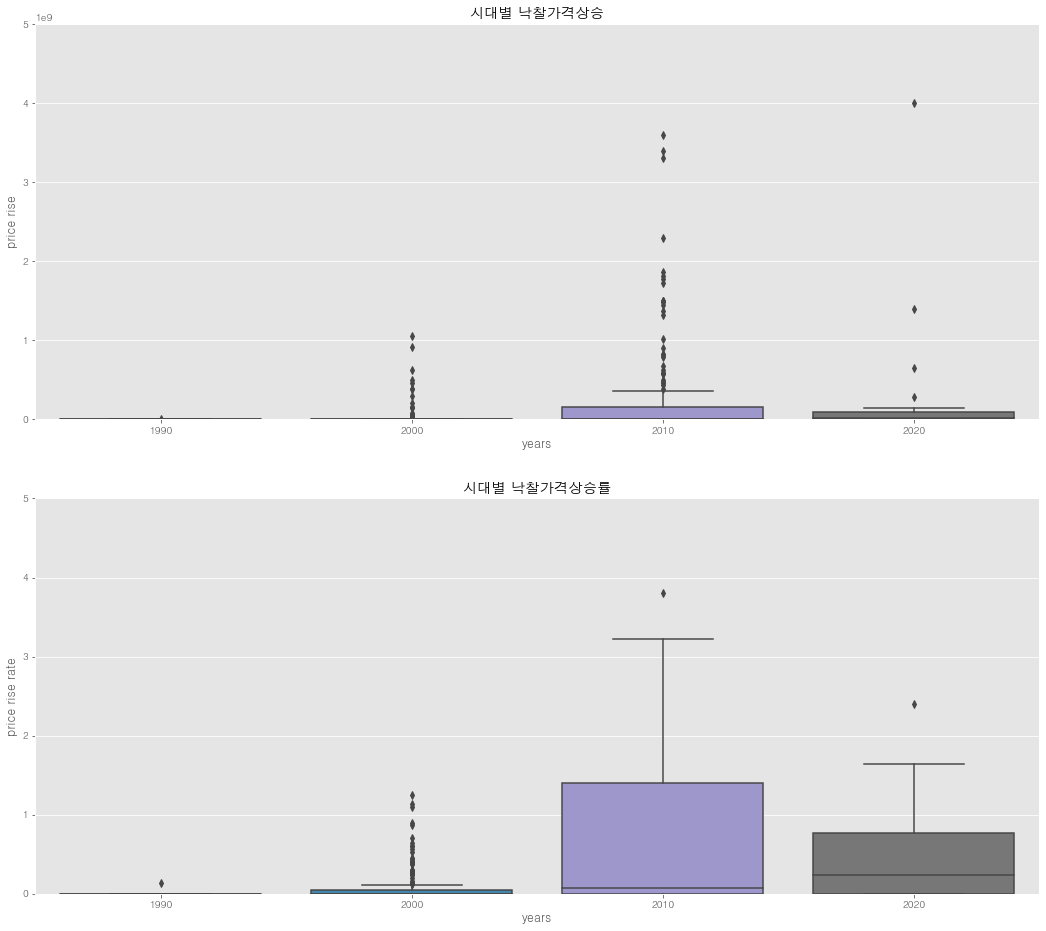

In [42]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18, 16)

sns.boxplot(data=train,y="price_rise",x="10year",orient="v",ax=axes[0])
sns.boxplot(data=train,y="price_rise_rate",x="10year",orient="v",ax=axes[1])

axes[0].set(xlabel='years', ylabel='price rise', title="시대별 낙찰가격상승",ylim=(0,0.5e10))
axes[1].set(xlabel='years', ylabel='price rise rate',title="시대별 낙찰가격상승률",ylim=(0,5))


In [43]:
def concatenate_year_month(data):
    return (data['auction_year']//5)*5

train["5year"] = train.apply(concatenate_year_month,axis=1)

print(train.shape)
train[["5year"]].head()

(423, 16)


,5year
0,2020
1,2020
2,2020
3,2020
4,2020


[Text(0.5, 0, 'years'),
 Text(0, 0.5, 'price rise rate'),
 Text(0.5, 1.0, '시대별 낙찰가격상승률'),
 (0.0, 5.0)]

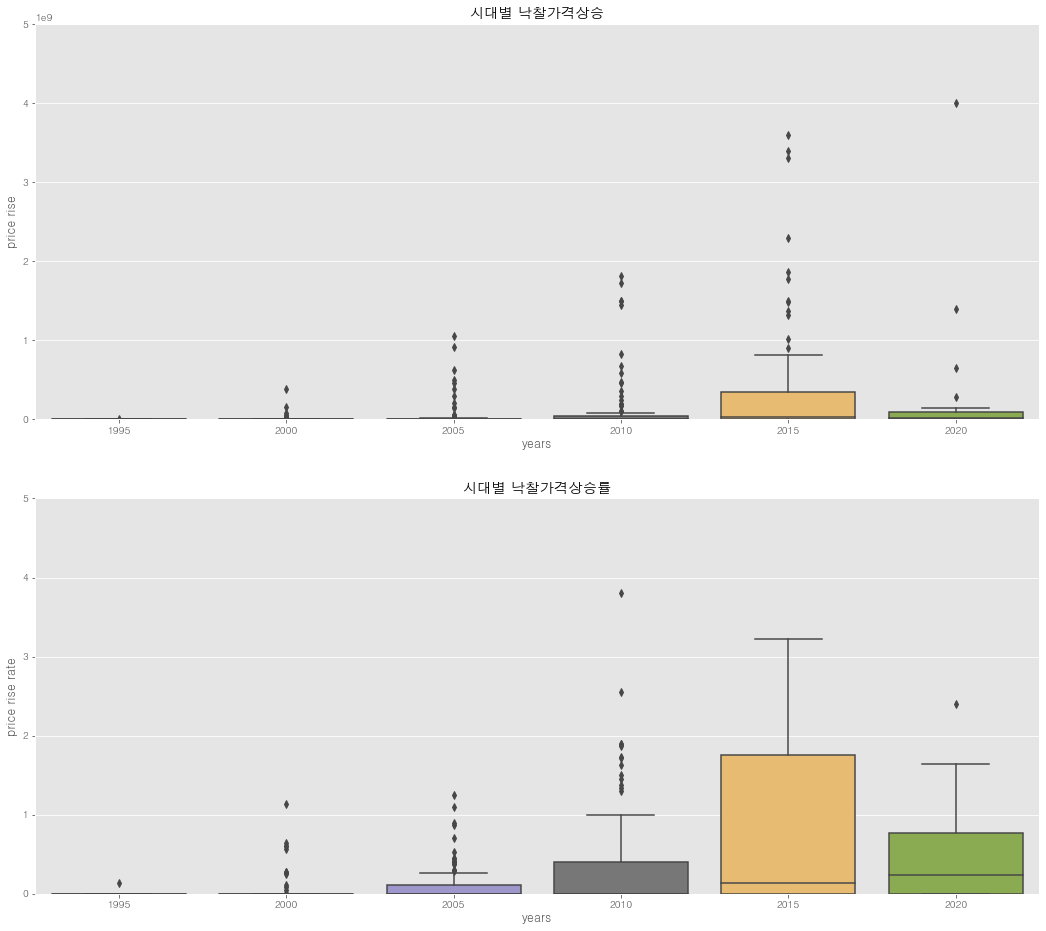

In [44]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18, 16)

sns.boxplot(data=train,y="price_rise",x="5year",orient="v",ax=axes[0])
sns.boxplot(data=train,y="price_rise_rate",x="5year",orient="v",ax=axes[1])

axes[0].set(xlabel='years', ylabel='price rise', title="시대별 낙찰가격상승",ylim=(0,0.5e10))
axes[1].set(xlabel='years', ylabel='price rise rate',title="시대별 낙찰가격상승률",ylim=(0,5))


In [46]:
fig.savefig('savefig_default.png')

In [ ]:
# //*[@id="container"]/div[3]/div/form/fieldset/div/div[1]/div[2]/dl[1]/dd/div/input[1]
#container > div.contents_wrap > div > form > fieldset > div > div.btn_wrap > span.btn_style01.gray02 > button


# resp = requests.get(url, data={'searchContent':artist})
# html_src = resp.text
# soup = BeautifulSoup(html_src, 'html.parser')

# soup
#container > div.contents_wrap > div > form > fieldset > div > div.search_box > div:nth-child(2) > dl:nth-child(1) > dd > div > input:nth-child(1)

# subway_image = soup.select('#mw-context-text > div > table:nth-child(3) > tbody > tr:nth-child(2) > td > a > img')
#mw-content-text > div.mw-parser-output > table:nth-child(3) > tbody > tr:nth-child(1) > td > a > img

# subway_image = soup.select('tr > td > a > img')
# print(subway_image)

# xpath, 조금 더 간결하게 접근이 가능함
# soup.XPath('//*[@id="mw-content-text"]/div[1]/table[1]/tbody/tr[1]/td/a/img')

# #siteNotice : ID selector .mw-headline class를 의미 tag와 함께 사용할 수 있음

# id_selector = soup.select('#siteNotice')
# print(id_selector)


#auctionList > li:nth-child(5) > div.result_auction_img_wrap.ng-scope > div > a > span > img

#container > div.contents_wrap > div > form > div > div.left > div > paging > ul > li:nth-child(14) > a